# Paper Plots

This notebook contains the code for making the plots in the offline analysis paper, EXO-23-002.

In [24]:
import os, sys, glob
import numpy as np
import matplotlib.pyplot as plt
import matplotlib
import mplhep as hep
import math
import warnings
import scipy
from plot_utils import *
import uproot
from scipy.stats import chi2
from matplotlib import ticker
from hist import Hist

warnings.filterwarnings('ignore')
hep.style.use("CMS")
matplotlib.rcParams.update({'figure.max_open_warning': 0})
matplotlib.rcParams['figure.facecolor'] = 'white'

In [2]:
## parameters
output_label = '/home/submit/{}/public_html/SUEP/plots/debug/'.format(os.environ['USER'])
plotDir = '/data/submit/{}/SUEP/outputs/'.format(os.environ['USER'])
outFile = 'data.root'

In [3]:
# create output dir
if not os.path.isdir(output_label): 
    print("Creating", output_label)
    os.mkdir(output_label)

# generate list of files that you want to read histograms for
offline_files_2018 = getHistLists(plotDir, 'unblind', '../filelist/Offline/list_2018_JetHT_A02_offline.txt')
offline_files_2017 = getHistLists(plotDir, 'unblind', '../filelist/Offline/list_2017_JetHT_A02_offline.txt')
offline_files_2016 = getHistLists(plotDir, 'unblind', '../filelist/Offline/list_2016_JetHT_A02_offline.txt')

In [4]:
plots_2018 = loader(offline_files_2018, auto_lumi=True, exclude_low_bins=True)
plots_2017 = loader(offline_files_2017, auto_lumi=True, exclude_low_bins=True)
plots_2016 = loader(offline_files_2016, auto_lumi=True, exclude_low_bins=True)

In [5]:
plots = {}

for key in plots_2018.keys(): plots[key+"_2018"] = plots_2018[key]
for key in plots_2017.keys(): plots[key+"_2017"] = plots_2017[key]
for key in plots_2016.keys(): plots[key+"_2016"] = plots_2016[key]

combineYears(plots, 'data', ['2018', '2017', '2016'])

## ABCD Regions Distribution

In [6]:
def compute_poisson_interval(values, confidence=0.6827):
    alpha = 1 - confidence
    low = chi2.ppf(alpha / 2., 2 * values) / 2
    high = chi2.ppf(1. - alpha / 2., 2 * (values + 1)) / 2
    if hasattr(low, '__len__'): low[np.isnan(low)] = 0
    return low, high

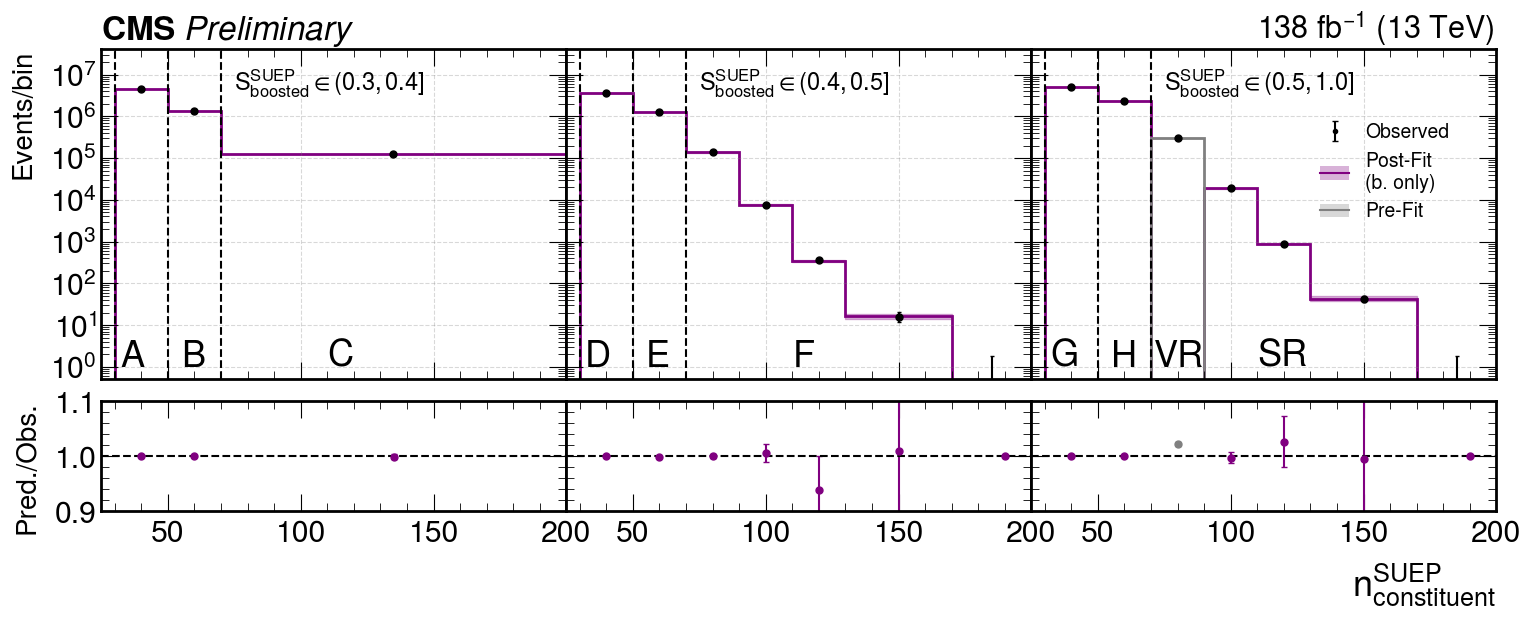

In [47]:
plot_label = '2D_SUEP_S1_vs_SUEP_nconst_Cluster70'
abcd = plots['data_all'][plot_label][::,::] 
xregions = [0.3j, 0.4j, 0.5j, 1.0j]
yregions = [30j, 50j, 70j, 300j]

_, SR_exp = ABCD_9regions_errorProp(abcd, xregions, yregions, sum_var='x')
SR_exp = rebin_piecewise(SR_exp, [70, 90, 110, 130, 170, 200])

fig, axes = plt.subplots(nrows=2, ncols=3, figsize=(18, 6), sharey=False,sharex=True, 
                         gridspec_kw={'height_ratios': [3,1], 'hspace':0.1, 'wspace':0}) #Plot 3 subplots
fig.subplots_adjust(wspace=0) #Plot 
(ax1, ax2, ax3) = axes[0]
(ax1r, ax2r, ax3r) = axes[1]

slicing = [30,50,70,200] #The boundary of the ABCD regions 
label_positions = [32,55,110] #The positions of the letters
colormap = plt.cm.get_cmap('Pastel1')
colors = [colormap(0.3),colormap(0.5),colormap(0.8),colormap(0.8),colormap(0.8),colormap(0.8),colormap(0.8)]
colors = ['purple']*len(colors)

ymax = 4e6

# Plot the distributions in every region
regions = {'A':(ax1,0),
           'B':(ax1,1),
           'C':(ax1,2),
           'D':(ax2,0),
           'E':(ax2,1),
           'F':(ax2,2),
           'G':(ax3,0),
           'H':(ax3,1),
           'I':(ax3,2)}

postfits = np.array([
    4638038.0 ,
    1343549.8 ,
    127470.81 ,
    3649479.0 ,
    1295964.0 ,
    136524.72 ,
    7678.991 ,
    345.368 ,
    16.168629 ,
    3.4765308e-06 ,
    4971188.0 ,
    2309313.0 ,
    np.nan ,
    18823.39 ,
    880.7299 ,
    42.82435 ,
    1.1720014e-05 ,
])
postfit_errs = np.array([
    2123.3659944305855 ,
    1126.410215509432 ,
    359.2458458447176 ,
    1941.9553842222333 ,
    1126.635963516508 ,
    368.41880141918887 ,
    86.38887122267921 ,
    13.403508531351386 ,
    2.2734110309361637 ,
    0.000837367510536049 ,
    2287.281867587071 ,
    1463.239655601415 ,
    np.nan ,
    129.4125252545653 ,
    25.90025519322387 ,
    5.832344331215792 ,
    0.0028966206157405474 ,
])
prefits = SR_exp.values()
prefit_errs = np.sqrt(SR_exp.variances()) 

observed = []
observed_errs_down, observed_errs_up = [], []
postfit_index = 0
with uproot.recreate(outFile) as froot:
    
    froot['SR_exp_SUEP_nconst'] = SR_exp
    
    for letter, (axis,i) in regions.items():

        h = plots['data_all'][letter + '_SUEP_nconst_Cluster70']
        h = h[slicing[i]*1j:slicing[i+1]*1j]
                
        if letter not in ['I', 'F']:
            edges = [h.axes[0].edges[0], h.axes[0].edges[-1]]
            #h = rebin_piecewise(h, edges)
            total = np.array([h[::sum].value])
            low, high = compute_poisson_interval(total)
            yerr = (total - low, high - total)
            axis.errorbar((edges[0]+edges[1])/2, total, yerr=yerr, linestyle='',c='black',ms=10,capsize=1.5,fmt ='.')
            observed.extend(total)
            observed_errs_down.extend(total - low)
            observed_errs_up.extend(high - total)
        else:
            h = rebin_piecewise(h, [70, 90, 110, 130, 170, 200])
            values, edges = h.to_numpy()
            low, high = compute_poisson_interval(values)
            yerr = (values - low, high - values)
            axis.errorbar(h.axes[0].centers, values, yerr=yerr, linestyle='',c='black',ms=10,capsize=1.5,fmt ='.')
            observed.extend(values)
            observed_errs_down.extend(values - low)
            observed_errs_up.extend(high - values)
            
        # postfit
        h_postfit =  Hist.new.Variable(edges, name="SUEP_nconst_postfit").Weight()
        this_postfit_vals = postfits[postfit_index:postfit_index+len(edges)-1]
        this_postfit_errs = postfit_errs[postfit_index:postfit_index+len(edges)-1]
        this_postfit_vals[np.isnan(this_postfit_vals)] = 0
        this_postfit_errs[np.isnan(this_postfit_errs)] = 0
        
        h_postfit[:] = np.stack([this_postfit_vals, this_postfit_errs], axis=-1)
        postfit_index += len(edges) - 1
            
        if letter == 'I': letter = 'SR'
       
        froot[letter + '_SUEP_nconst'] = h
        froot['postfit_' + letter + '_SUEP_nconst'] = h_postfit
                
        axis.text(label_positions[i],1,str(letter))
        
        
edges = np.array([
    30,
    50,
    70,
    90,
    110,
    130,
    170,
    200
])
centers = np.array([
    40,
    60,
    135,
    40,
    60,
    80,
    100,
    120,
    150,
    190,
    40,
    60,
    80,
    100,
    120,
    150,
    190
])
       

ax1_postfits = []
ax2_postfits = []
ax3_postfits = []
ax1_edges = []
ax2_edges = []
for i in range(len(edges)-1):
    if i < 2:
        #ax1.stairs([postfits[i]], [edges[i], edges[i+1]], fill=False, color=colors[i])
        ax1_postfits.append(postfits[i])
        ax1_edges.append(edges[i])
        #ax1_edges.append(edges[i+1])
        ax1.fill_between([edges[i], edges[i+1]],[postfits[i] - postfit_errs[i]], [postfits[i] + postfit_errs[i]], color='purple',alpha=0.3)
            
    elif i == 2:
        ax1_postfits.append(postfits[i])
        ax1_edges.append(edges[i])
        ax1_edges.append(edges[-1])
        #ax1.stairs([postfits[i]], [edges[i], edges[-1]], fill=False, color=colors[i])
        ax1.fill_between([edges[i], edges[-1]],[postfits[i] - postfit_errs[i]], [postfits[i] + postfit_errs[i]], color="purple",alpha=0.3)

    #ax2.stairs([postfits[i+3]], [edges[i], edges[i+1]], fill=False, color=colors[i])
    ax2.fill_between([edges[i], edges[i+1]],[postfits[i+3] - postfit_errs[i+3]], [postfits[i+3] + postfit_errs[i+3]], color="purple",alpha=0.3)
    ax2_postfits.append(postfits[i+3])
    ax3_postfits.append(postfits[i+10])
    ax2_edges.append(edges[i])
    if i == len(edges) - 2:
        ax2_edges.append(edges[-1])
    
    #ax3.stairs([postfits[i+10]], [edges[i], edges[i+1]], fill=False, color=colors[i])
    ax3.fill_between([edges[i], edges[i+1]],[postfits[i+10] - postfit_errs[i+10]], [postfits[i+10] + postfit_errs[i+10]], color="purple",alpha=0.3)

ax1.stairs(ax1_postfits, ax1_edges, color='purple', lw=2, fill=False)    
ax2.stairs(ax2_postfits, ax2_edges, color='purple', lw=2, fill=False)    
ax3.stairs(ax3_postfits, ax2_edges, color='purple', lw=2, fill=False) 

for i, bound in enumerate([[0,3],[3,10],[10,None]]):
    this_centers = centers[bound[0]:bound[1]]
    this_postfits = postfits[bound[0]:bound[1]]
    this_observed = np.array(observed[bound[0]:bound[1]])
    this_postfit_errs = postfit_errs[bound[0]: bound[1]]
    this_observed_errs_up = np.array(observed_errs_up[bound[0]:bound[1]])
    this_observed_errs_down = np.array(observed_errs_down[bound[0]:bound[1]])    
    this_ratio_err_low = np.where(
        this_observed > 0,
        np.sqrt(
            (this_observed ** -2) * (this_postfit_errs**2)
            + (this_postfits ** 2 * this_observed ** -4) * (this_observed_errs_down**2)
        ),
        0,
    )
    this_ratio_err_high = np.where(
        this_observed > 0,
        np.sqrt(
            (this_observed ** -2) * (this_postfit_errs**2)
            + (this_postfits ** 2 * this_observed ** -4) * (this_observed_errs_up**2)
        ),
        0,
    )
    ratio = np.where(this_observed > 0,
        this_postfits/this_observed,
        1
    )
        
    # axes[0,i].errorbar(this_centers-5, this_postfits, 
    #                   yerr=this_postfit_errs, linestyle='',c='purple',capsize=2.0,ms=10)
    axes[1,i].errorbar(this_centers, ratio, yerr=np.array([this_ratio_err_low, this_ratio_err_high]),
                       linestyle='',c='purple',ms=10,capsize=2.0,fmt ='.')
    
    if i == 2:
        this_observed = np.array(observed[bound[0]+2:bound[0]+3])
        this_observed_errs_up = np.array(observed_errs_up[bound[0]+2:bound[0]+3])
        this_observed_errs_down = np.array(observed_errs_down[bound[0]+2:bound[0]+3])  
        this_prefits = prefits[0:1]
        this_prefit_errs = prefit_errs[0:1]
                        
        this_ratio_err_low = np.where(
            this_observed > 0,
            np.sqrt(
                (this_observed ** -2) * (this_prefit_errs**2)
                + (this_prefits ** 2 * this_observed ** -4) * (this_observed_errs_down**2)
            ),
            0,
        )
        this_ratio_err_high = np.where(
            this_observed > 0,
            np.sqrt(
                (this_observed ** -2) * (this_prefit_errs**2)
                + (this_prefits ** 2 * this_observed ** -4) * (this_observed_errs_up**2)
            ),
            0,
        )
        ratio = np.where(this_observed > 0,
            this_prefits/this_observed,
            1
        )
        
        axes[0,i].stairs(this_prefits, [edges[i], edges[i+1]], color='gray',lw=2,fill=False)
        axes[0,i].fill_between([edges[i], edges[i+1]],this_prefits - this_prefit_errs, this_prefits + this_prefit_errs, color="gray",alpha=0.3)
        axes[1,i].errorbar(this_centers[2], ratio, yerr=np.array([this_ratio_err_low, this_ratio_err_high]),
                       linestyle='',c='gray',capsize=2.0,ms=10,fmt ='.')

ax1r.axhline(1, ls="--", color="black")
ax2r.axhline(1, ls="--", color="black")
ax3r.axhline(1, ls="--", color="black")

#Adjust the figure and add labels 
ytop = ymax *10 # The upper limit for the yaxis
for ax in axes[0]:
    ax.set_yscale('log')
    ax.set_ylim(0.5,ytop)
    ax.vlines([30,50,70],0.5,ytop,color='black',linestyle='--') #Take bin edges
    ax.set_xlim(25, 200)
    
    ax.grid(visible=True, which='major', color='grey', linestyle='--', alpha=0.3)

    y_major = ticker.LogLocator(base = 10.0, numticks = 20)
    ax.yaxis.set_major_locator(y_major)
    y_minor = ticker.LogLocator(base = 10.0, subs = np.arange(1.0, 10.0) * 0.1, numticks = 100)
    ax.yaxis.set_minor_locator(y_minor)
    ax.yaxis.set_minor_formatter(ticker.NullFormatter())
    
ax1.set_ylabel('Events/bin',labelpad=10,fontsize=20)
ax1r.set_ylabel('Pred./Obs.',labelpad=10,fontsize=20)

ax3r.set_xlabel('$n^{SUEP}_{constituent}$', labelpad=10, loc='right')

ax1.text(75,ymax,r"$S^{\mathrm{SUEP}}_{\mathrm{boosted}} \in (0.3,0.4]$",fontsize=17)
ax2.text(75,ymax,r"$S^{\mathrm{SUEP}}_{\mathrm{boosted}} \in (0.4,0.5]$",fontsize=17)
ax3.text(75,ymax,r"$S^{\mathrm{SUEP}}_{\mathrm{boosted}} \in (0.5,1.0]$",fontsize=17)

# rectangle = plt.Rectangle((70, 1e-2), 20, prefits[0], color='lightgray', alpha=1)
# ax3.add_patch(rectangle)
ax3.text(71, 1, 'VR', rotation=0)


axes[1, 0].get_shared_y_axes().join(axes[1, 0], axes[1, 1], axes[1, 2])
ax1r.set_ylim(0.9, 1.1)

for i in range(2):
    for j in range(3):
        if j > 0:  # Check if the column is not the first column
            axes[i, j].set_yticklabels([])  # Remove y-axis labels


import matplotlib.patches as mpatches
from matplotlib.legend_handler import HandlerLine2D

line, = plt.plot(range(10), color = 'purple')
patch = mpatches.Patch(facecolor='purple', alpha=0.3, linewidth=0)
line2, = plt.plot(range(10), color = 'gray')
patch2 = mpatches.Patch(facecolor='gray', alpha=0.3, linewidth=0)
line3 = plt.errorbar(1000,0, yerr=10, label='Observed', linestyle='',c='black',capsize=2.0,fmt ='.')
ax3.legend([line3, (patch, line), (patch2, line2)], ["Observed", "Post-Fit\n(b. only)", "Pre-Fit"], handler_map = {line : HandlerLine2D(marker_pad = 0)}, 
           loc=(0.6,0.45), fontsize=14)

#ax3.legend(loc=(0.6,0.45), fontsize=14)


# Add CMS statements
cms = ax1.text(
    25, ytop*1.7, u"CMS $\it{Preliminary}$",
    fontsize=24, fontweight='bold',
)

lumi = ax3.text(
    110, ytop*1.7, r"%.0f fb$^{-1}$ ($13$ TeV)" % round(lumiLabel('2016')+lumiLabel('2017')+lumiLabel('2018')),
    fontsize=22,
)

fig.tight_layout()
#plt.autoscale()

#plt.savefig('/home/submit/{}/SUEP/EXO-23-002/images/all_regions.pdf'.format(os.environ['USER']),format='pdf',bbox_inches='tight')

The remaining plots in the paper can be made using the SUEPLimits repo.